# Loan Prediction

Our purpose is to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. 

| Column | Description |
| --- | :-- |
| Loan_ID | Unique loan ID |
| Gender | |
| Dependents | Number of applicant's dependents |
| Married | Yes - married, No - not married |
| Education | Graduate/not graduate |
| Self_Employment | If applicant is self-employed |
| ApplicantIncome | |
| CoapplicantIncome| |
| LoanAmount | Loan amount in thousands |
| Loan_Amount_Term | Term of loan in months |
| Credit_History | If credit history meets the requirements - 1, if not - 0 |
| Property_Area | Urban/Semiurban/Rural |
| Loan_Status | Y - loan approved, N - loan refused |

## Dowloading the data

In [1]:
import pandas as pd
import numpy as np

path = 'C:/Users/user/Downloads/loan_data.csv'
data = pd.read_csv(path)

## Exploring the data set

Let's see the data set info.

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 43.2+ KB


As we can see, there are some missing values. We will deal with them later.

First 5 records:

In [3]:
print(data.head())

    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0   

Some numeric variables' statistics:

In [4]:
print(data.describe())

       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  592.000000         600.00000   
mean       5403.459283        1621.245798  146.412162         342.00000   
std        6109.041673        2926.248369   85.587325          65.12041   
min         150.000000           0.000000    9.000000          12.00000   
25%        2877.500000           0.000000  100.000000         360.00000   
50%        3812.500000        1188.500000  128.000000         360.00000   
75%        5795.000000        2297.250000  168.000000         360.00000   
max       81000.000000       41667.000000  700.000000         480.00000   

       Credit_History  
count      564.000000  
mean         0.842199  
std          0.364878  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000  


## Data visualisation

Because column 'Loan_Status' has type 'object', we should change it to numeric.

In [5]:
data['Loan_Status'].replace({'Y': 1, 'N': 0}, inplace = True)

Let's define two functions that will shorten our code. First one shows a proportion of approved loans in groups defined by categorical variables. Second one shows boxplots of numeric variables grouped by the loan status.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def proportion(col, xlabel):
    sns.catplot(x = col, y = 'Loan_Status', kind = 'bar', 
                data = data[[col, 'Loan_Status']].dropna())
    plt.xlabel(xlabel)
    plt.ylabel('Proportion of approved loans')
    plt.show()
    
def boxplot(col, ylabel):
    sns.boxplot(x = 'Loan_Status', y = col, 
                data = data[[col, 'Loan_Status']].dropna())
    plt.xlabel('Loan approved')
    plt.xticks(np.arange(2),['No', 'Yes'])
    plt.ylabel(ylabel)
    plt.show()

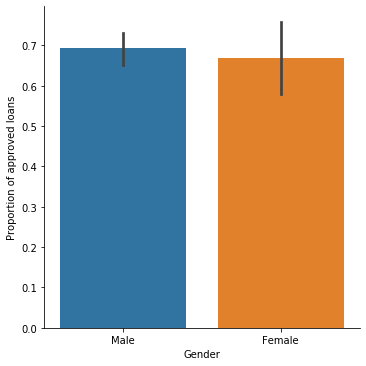

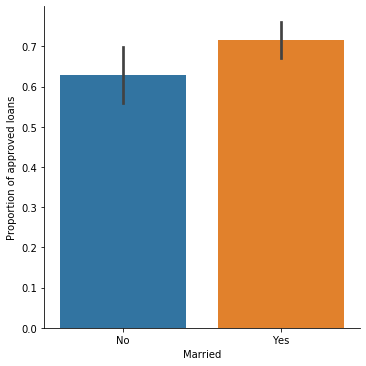

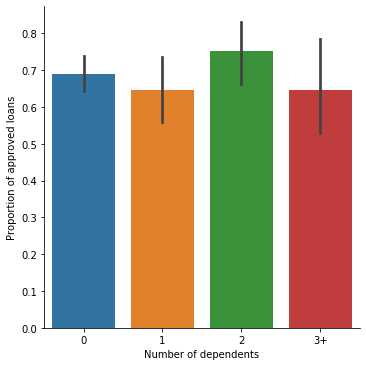

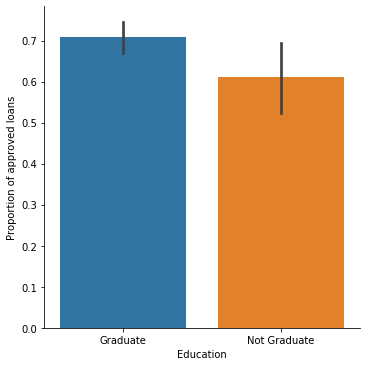

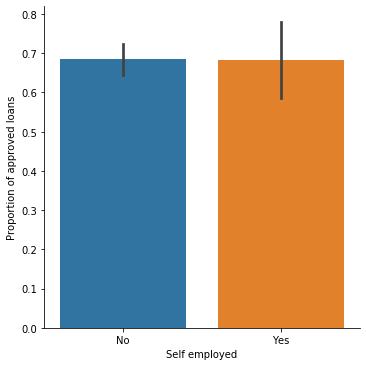

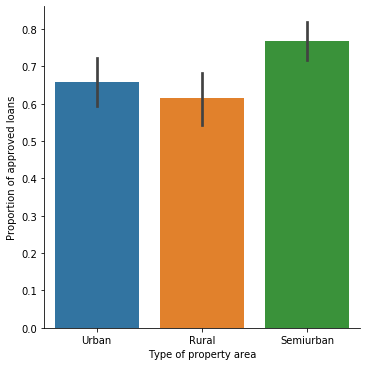

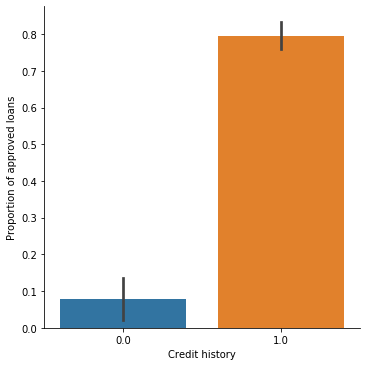

In [7]:
proportion('Gender', 'Gender')
proportion('Married', 'Married')
proportion('Dependents', 'Number of dependents')
proportion('Education', 'Education')
proportion('Self_Employed', 'Self employed')
proportion('Property_Area', 'Type of property area')
proportion('Credit_History', 'Credit history')

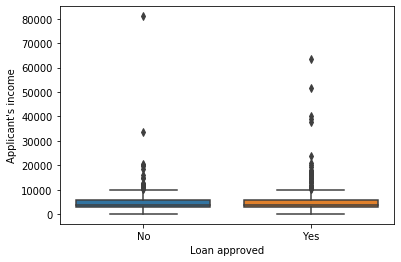

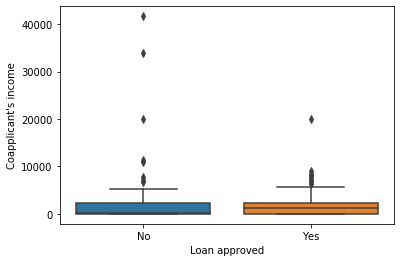

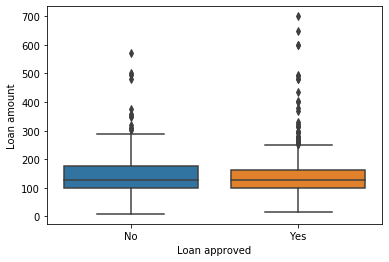

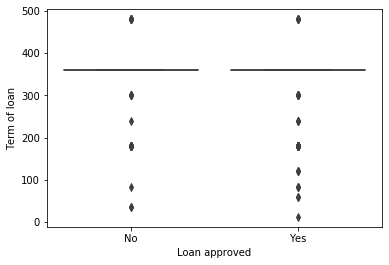

In [8]:
boxplot('ApplicantIncome', "Applicant's income")
boxplot('CoapplicantIncome', "Coapplicant's income")
boxplot('LoanAmount', 'Loan amount')
boxplot('Loan_Amount_Term', 'Term of loan')  

## Logistic Regression

Let's divide our data into y ('Loan_Status') and X (all other variables except 'Loan_ID').

In [9]:
y = data.Loan_Status
X = data.drop(['Loan_ID', 'Loan_Status'], axis = 1)

Train-test split:

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2)

Defining of categorical and numeric variables:

In [11]:
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']

num_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

We will create a pipeline which imputes missing values with the most frequent value along each categorical column and then performs one-hot encoding of them.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

pipeline_1 = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder())
    ])

Then we will create a column tranformer that replaces missing values along numerical columns (with the median for 'Credit_History' and the mean for other variables) and uses pipeline_1 for categorical variables.

In [13]:
from sklearn.compose import ColumnTransformer

transform_1 = ColumnTransformer(transformers = [
    ('history', SimpleImputer(strategy = 'median'), ['Credit_History']),
    ('num', SimpleImputer(strategy = 'mean'), num_cols),
    ('categorical', pipeline_1, categorical_cols)
    ])

Specifying the model:

In [14]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter = 1000, penalty = 'l2', 
                             solver = 'liblinear')

Now we will create a pipeline that will use previously defined column transformer and fit the model to our data.

In [15]:
pipeline_2 = Pipeline(steps = [
    ('preprocessing', transform_1),
    ('model', model)
    ])

Fitting the model to train sets:

In [16]:
reg = pipeline_2.fit(X_train, y_train)

Predictions from validation data:

In [17]:
pred = reg.predict(X_valid)

Finally, calculating classification metrics:

In [18]:
from sklearn import metrics

print(metrics.classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       0.95      0.58      0.72        33
           1       0.86      0.99      0.92        90

    accuracy                           0.88       123
   macro avg       0.91      0.78      0.82       123
weighted avg       0.89      0.88      0.87       123



We can see high precision of class 0 (0.95) and recall of class 1 (0.99). It means that if our model rejects a loan, it almost always will be rejected by a bank employee and we will not lose a lot of potential clients using this model. However, low recall of class 0 (0.58) means that bank employees should still review all applications approved by the model.